In [1]:
from __future__ import print_function

import glob
import numpy as np
import tensorflow as tf
import os
import scipy.misc
import matplotlib.pyplot as plt

import keras
from keras import applications, metrics, layers, models, regularizers, optimizers
from keras.callbacks import *
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform

import psutil
from sklearn.metrics import confusion_matrix

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
def get_flag(filePath):
    
    NAME = os.path.split(filePath)[-1]
    FLAG = NAME[-5]
    return int(FLAG)

def calc_tss(confmat, nClasses):
    stats = {"recall": np.array([]), "Accuracy": np.array([]), "TSS": np.array([])}
    for i in xrange(0, nClasses):
        tp = confmat[i,i]
        tn = 0.0
        for j in range (i+1,nClasses):
            tn += confmat[j,j]
        for j in range (0,i):
            tn += confmat[j,j]
        fp = confmat[:,i].sum() - tp
        fn = confmat[i,:].sum() - tp
        myscore = float(( tp + tn )) / ( tp + tn + fp + fn)
        stats["Accuracy"] = np.append(stats["Accuracy"], myscore)
        myscore = float( tp ) / (tp + fn )
        stats["recall"] = np.append(stats["recall"], myscore)
        myscore = float( tp ) / ( tp + fn ) - float( fp ) / ( fp + tn )
        stats["TSS"] = np.append(stats["TSS"], myscore)
    print(stats)

In [3]:
model = load_model('inception_with_generator/model_3.h5')

"""
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
rasha_model = model_from_json(loaded_model_json)
rasha_model.load_weights("weights.h5")
"""
#rasha_model = load_model("model_epoch05_acc073.h5")

'\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nrasha_model = model_from_json(loaded_model_json)\nrasha_model.load_weights("weights.h5")\n'

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 125, 125, 8)  400         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 125, 125, 8)  32          conv2d_91[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_91 (LeakyReLU)      (None, 125, 125, 8)  0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
max_poolin

In [5]:
#test_files = np.load('rasha_test_128.npy')


testFlare = ['5956', '5974', '5982', '5983', '6015', '6026', '6052', '6063',
       '6078', '6205', '6206', '6327', '6483', '6670', '6870', '6972',
       '7075', '7110', '7115', '7169']

testNonFlare = ['5935', '5944', '5961', '5963', '5970', '5976', '5990', '5991',
       '5996', '6004', '6006', '6013', '6027', '6060', '6075', '6084',
       '6093', '6099', '6100', '6104', '6115', '6124', '6136', '6140',
       '6154', '6155', '6159', '6164', '6167', '6172', '6174', '6178',
       '6192', '6223', '6224', '6230', '6242', '6246', '6247', '6258',
       '6273', '6281', '6284', '6289', '6301', '6302', '6313', '6317',
       '6319', '6320', '6324', '6326', '6351', '6359', '6361', '6375',
       '6379', '6383', '6398', '6399', '6403', '6409', '6418', '6424',
       '6437', '6454', '6464', '6498', '6500', '6505', '6507', '6510',
       '6515', '6518', '6523', '6532', '6537', '6544', '6545', '6550',
       '6556', '6558', '6566', '6576', '6594', '6599', '6613', '6615',
       '6617', '6620', '6626', '6648', '6657', '6662', '6664', '6666',
       '6683', '6692', '6693', '6699', '6703', '6711', '6715', '6716',
       '6722', '6728', '6731', '6737', '6745', '6754', '6759', '6764',
       '6769', '6774', '6780', '6789', '6794', '6798', '6803', '6804',
       '6810', '6815', '6820', '6829', '6838', '6846', '6863', '6868',
       '6869', '6870', '6892', '6910', '6920', '6922', '6930', '6939',
       '6949', '6951', '6952', '6961', '6975', '6982', '6983', '6986',
       '6988', '6994', '6999', '7016', '7022', '7030', '7034', '7045',
       '7050', '7058', '7068', '7081', '7096', '7100', '7107', '7117',
       '7120', '7122', '7123', '7127', '7131', '7144', '7147', '7148',
       '7171', '7189', '7192', '7211', '7229', '7237', '7251', '7256',
       '7261', '7262', '7269', '7274', '7275', '7276', '7283', '7299',
       '7300', '7323', '7325', '7331', '7334', '7341', '7348']


rasha_test_files = []

regions = testFlare + testNonFlare

missing_rgn = []
for rgn in regions:
    pthstr = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat' %(rgn)
    paths = glob.glob(pthstr)
    if(len(paths) == 0):
        missing_rgn.append(rgn)
    
    rasha_test_files.extend(paths)

In [13]:
files = []
for ar in testNonFlare:
    arstr = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat' %(ar)
    files.extend(glob.glob(arstr))
    
print(len(files))

38517


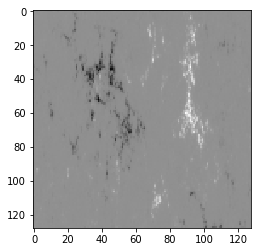

In [57]:
img = np.load(rasha_test_files[0])
plt.imshow(img, cmap="gray")

In [7]:
pred_arr = []
act_arr = []
np.random.shuffle(rasha_test_files)
for fl in rasha_test_files:
    img = np.load(fl)
    img = img.reshape(1, img.shape[0], img.shape[1], 1)
    pred = float(model.predict(img))
    #print(pred)
    if (pred < 0.5):
        pred = 0
    else:
        pred = 1
        
    pred_arr.append(pred)
    act = get_flag(fl)
    act_arr.append(act)


confmat = confusion_matrix(act_arr, pred_arr)
calc_tss(confmat,2)

{'recall': array([0.80668339, 0.69361613]), 'TSS': array([0.50029952, 0.50029952]), 'Accuracy': array([0.79417232, 0.79417232])}
